In [ ]:
pip install duckduckgo_search langchain_groq sentence_transformers faiss-cpu pydantic python-dotenv pypdf bs4 langchain langchain_core langchain-community langchain_huggingface langchain_google_genai langchain-pinecone langgraph langchain-openai langchain_groq langchain_google_genai google-generativeai  pymupdf wikipedia arxiv defusedxml  youtube_search langchain-tavily langgraph chromadb


In [13]:
#### import
import os
import pprint
from dotenv import load_dotenv
from langgraph.graph import Graph
from IPython.display import Image, display
load_dotenv()


True

In [14]:
### Configure the Model
from langchain_groq import ChatGroq
model = ChatGroq(model="deepseek-r1-distill-llama-70b")
query = "Hi"
response = model.invoke(query)
pprint.pprint(response.content)



'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'


In [15]:
### Configure the Embedding
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
embed_query = embeddings.embed_query(query)
len(embed_query)


384

In [16]:
# Lets take a Data embedd it and store in Vector Database
##### Imports
import requests
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
from langchain_core.tools import tool
from langchain.tools import tool
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph,END,MessagesState,START
from langgraph.prebuilt import ToolNode

In [17]:
# Travel Agent Tool
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import re

weather_api_key = os.getenv("WEATHER_API_KEY")

class TravelAgent:
    """Handles general travel planning queries."""
    @tool
    def travel_agent(query:str) -> str:
        """Handles general travel planning queries."""
        return f"Travel Agent : I can help plan your trip. You asked : {query} "
    
class WeatherAgent:
    
    def __init__(self, api_key):
        
        self.api_key = api_key
        self.base_url = "https://api.openweathermap.org/data/2.5/weather"
        
    
    def get_weather_city(self, city: str) -> str:
        """Provides weather information for a city."""
        
        params = {
        "q" : city,
        "appid" : self.api_key
        }
        response = requests.get(self.base_url, params=params)    
        if response.status_code == 200:
                
            data = response.json()
            weather_desc = data["weather"][0]["description"]
            temp = data["main"]["temp"]
            #humidity = data["main"]["humidity"]
            #wind_speed = data["wind"]["speed"]
            return {
                "city": city,
                "description": weather_desc,
                "temperature_celsius": temp
                #"humidity": humidity,
                #"wind_speed_m_s": wind_speed
            }
        else:
            return {"error": f"Coold not retrieve weather data for {city}"}
        
        return f"Weather Agent: The Weather is {city} is sunny and {temperature_celsius}."
                

class AttrationAgent:
    search = DuckDuckGoSearchRun()
    @tool
    def get_attraction_details(city: str) -> str:
        """Provides top attractions for a city."""
        city = city
        query = f"top 3 tourist attractions in {city}"
        results = AttrationAgent.search(query)
        # Use regex to extract lines that look like "1. Place Name" or similar
        place_names = re.findall(r'\d+\.\s*([A-Za-z0-9\s\'\-&]+)', results)
        # Remove duplicates and strip whitespace
        unique_places = []
        for name in place_names:
            clean_name = name.strip()
            if clean_name and clean_name not in unique_places:
                unique_places.append(clean_name)
        # Take top 3
        top_places = unique_places[:3]+"::"
        if top_places:
            return f"Attraction Agent: The top 3 attractions in {city} are: {', '.join(top_places)}."
        else:
            return f"Attraction Agent: Sorry, couldn't extract attractions for {city}."
        
    
class CurrencyAgent:
    @tool
    def get_currency_exchange_rate(currency: str) -> str:
        """Provides currency exchange rates."""
        return f"Currency Agent: The current exchange rate for {currency} is 1 {currency} = 1.2 USD."
    
search = DuckDuckGoSearchRun()
# search.invoke("What is the latest update on iPhone 17 relase ?")
WeatherAgent = WeatherAgent(api_key=weather_api_key)

# Register all agents/tools
mytools = [
    TravelAgent.travel_agent, 
    WeatherAgent.get_weather_city, 
    AttrationAgent.get_attraction_details, 
    CurrencyAgent.get_currency_exchange_rate, 
    search
]

llm_Trip_Agent = model.bind_tools(mytools)

SYSTEM_PROMPT = (
    "You are a helpful Travel Planner Agent. "
    "You can use the following agents: travel_agent, weather_agent, attraction_agent, currency_converter, search. "
    "Route the user's query to the correct agent(s) and combine their responses as needed."
)

# Supervisor orchestrates the workflow

    
def supervisor(state:MessagesState):
    USER_QUERY = state["messages"]
    INPUT_QUERY = [SYSTEM_PROMPT]+USER_QUERY

    response = llm_Trip_Agent.invoke(INPUT_QUERY)

    return {
        "messages" : [response]
    }


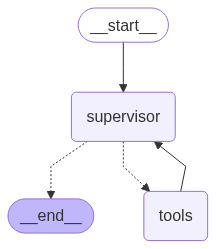

In [18]:

# Build the workflow graph
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

TravelAgent_workflow_builder = StateGraph(MessagesState)
TravelAgent_workflow_builder.add_node("supervisor", supervisor)
TravelAgent_workflow_builder.add_node("tools", ToolNode(mytools))
TravelAgent_workflow_builder.add_edge(START, "supervisor")
TravelAgent_workflow_builder.add_conditional_edges("supervisor", tools_condition,)
TravelAgent_workflow_builder.add_edge("tools","supervisor")
## React and Action
react_graph = TravelAgent_workflow_builder.compile()
react_graph

In [19]:
message = [HumanMessage(content="TravelAgent, what is the weather in Hyderabad and Attractions in Hyderabad and convert $20 to INR")]
#message = [HumanMessage(content="What are the top attractions and weather in Hyderabad?")]
response = react_graph.invoke({"messages": message})
#react_graph.compile()
##### Final Answer 
for m in response["messages"]:
    m.pretty_print()



================================ Human Message =================================

TravelAgent, what is the weather in Hyderabad and Attractions in Hyderabad and convert $20 to INR
================================== Ai Message ==================================
Tool Calls:
  get_weather_city (3k9hg35b9)
 Call ID: 3k9hg35b9
  Args:
    city: Hyderabad
================================= Tool Message =================================
Name: get_weather_city

{"city": "Hyderabad", "description": "overcast clouds", "temperature_celsius": 299.63}
================================== Ai Message ==================================

Here's the information you requested:

**Weather in Hyderabad:**  
- **City:** Hyderabad  
- **Description:** Overcast clouds  
- **Temperature:** 299.63°C (Note: This seems unusually high and might be in Kelvin. If converted to Celsius, it would be approximately 26.48°C.)

**Top Attractions in Hyderabad:**  
1. Charminar  
2. Golconda Fort  
3. Qutub Shahi Tombs  
4. Sal

In [20]:
message = [HumanMessage(content="TravelAgent, what is the weather in Hyderabad and Attractions in Hyderabad and convert $20 to INR")]
response = react_graph.invoke({"messages": message})



In [21]:
message = [HumanMessage(content="weather in hyderabad and convert $20 to INR")]
#message = [HumanMessage(content="What are the top attractions and weather in Hyderabad?")]
response = react_graph.invoke({"messages": message})
#react_graph.compile()
##### Final Answer 
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

weather in hyderabad and convert $20 to INR
================================== Ai Message ==================================
Tool Calls:
  get_weather_city (gjxgqn602)
 Call ID: gjxgqn602
  Args:
    city: Hyderabad
================================= Tool Message =================================
Name: get_weather_city

{"city": "Hyderabad", "description": "overcast clouds", "temperature_celsius": 299.63}
================================== Ai Message ==================================
Tool Calls:
  get_currency_exchange_rate (h9dc02697)
 Call ID: h9dc02697
  Args:
    currency: USD/INR
================================= Tool Message =================================
Name: get_currency_exchange_rate

Currency Agent: The current exchange rate for USD/INR is 1 USD/INR = 1.2 USD.
================================== Ai Message ==================================

In Hyderabad, the weather is overcast clouds with a